In [9]:
import requests
import csv
import pytz
import time
from datetime import datetime, timedelta

In [10]:
# start_ts = 1204329600  # 2008-03-01
start = datetime(2010, 7, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2014, 6, 1, 1, 0, 0)
prefix4 =  '192.36.148.17'
prefix6 = '2001:7fe::53'

### helper function

In [11]:
def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_state = []
    if data:
        for item in data:
            route_info = {
                'peer': item['path'][0],
                'root': item['path'][-1],
                'as_path': list(deduplicate(item['path']))
            }
            bgp_state.append(route_info)

    peer = [item['peer'] for item in bgp_state]

    return bgp_state, peer

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

### calculation

In [12]:
utc = pytz.utc
with open('i-root-mutual-as-path-stats.csv', 'w', newline='') as output_file:
    writer = csv.writer(output_file, delimiter=',')
    # csv header first
    writer.writerow(['time', 'identical', 'diff', 'v4_longer', 'v4_shorter'])
    cur_date = start
    while cur_date <= stop:
        print(cur_date)
        
        utc_dt = utc.localize(cur_date)
        timestamp = int(time.mktime(utc_dt.timetuple()))
        
        bgp_state4, peer4 = get_peers(prefix4, timestamp)
        bgp_state6, peer6 = get_peers(prefix6, timestamp)
        
        mutual_peers = list(set(peer4) & set(peer6))
        
        mutual_peers_stat = get_peers_stat(mutual_peers, bgp_state4, bgp_state6)
        
        time_str = cur_date.strftime('%Y-%m-%d')
        result_all = len([i['peer'] for i in mutual_peers_stat])
        result_identical = len([i['peer'] for i in mutual_peers_stat if i['similar'] == 1])
        result_diff = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) == len(i['path6']) and i['similar'] == 0])
        result_v4_longer = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) > len(i['path6'])])
        result_v4_shorter = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) < len(i['path6'])])
        
        writer.writerow((time_str, result_identical, result_diff, result_v4_longer, result_v4_shorter))
        
        year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
        month = 1 if cur_date.month == 12 else cur_date.month + 1
        cur_date = datetime(year, month, 1, 1, 0, 0)
    
    

2010-07-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.36.148.17&timestamp=1277942400
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:7fe::53&timestamp=1277942400
2010-08-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.36.148.17&timestamp=1280620800
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:7fe::53&timestamp=1280620800
2010-09-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.36.148.17&timestamp=1283299200
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:7fe::53&timestamp=1283299200
2010-10-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.36.148.17&timestamp=1285891200
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:7fe::53&timestamp=1285891200
2010-11-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.36.148.17&timestamp=128856

### Plot some graphs

In [6]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [7]:
df = pd.read_csv('i-root-mutual-as-path-stats.csv', index_col=0)
df

,identical,diff,v4_longer,v4_shorter
time,,,,
2010-06-18,1,2,0,23
2010-07-01,1,3,0,22
2010-08-01,0,2,0,20
2010-09-01,0,2,0,22
2010-10-01,0,2,0,23
2010-11-01,8,8,0,11
2010-12-01,4,0,0,1
2011-01-01,7,0,0,4
2011-02-01,14,6,3,11


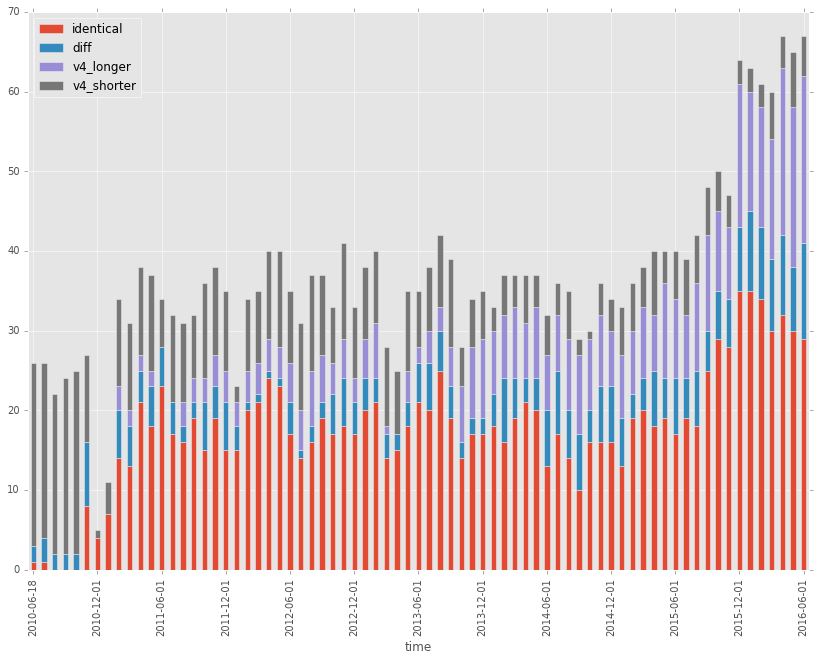

In [8]:
plot = df.plot.bar(stacked=True, figsize=(14,10))

n = 6

ticks = plot.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in plot.xaxis.get_ticklabels()]
plot.xaxis.set_ticks(ticks[::n])
plot.xaxis.set_ticklabels(ticklabels[::n])

# RQ: How different is IPv4 and IPv6 catchment areas?

## RQ.1 IPv4/IPv6 peer degree distribution?

In [1]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests

# matplotlib.style.use('ggplot')

timestamp = 1464739200 # 2013-06-01
# url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
prefix4 =  '192.36.148.17'
prefix6 = '2001:7fe::53'

Find out the mutual peers

In [2]:
col_map = {
    '00': 'RIPE NCC, Amsterdam',
    '01': 'LINX, London',
    '02': 'SFINX, Paris',
    '03': 'AMS-IX and NL-IX, Amsterdam',
    '04': 'CIXP, Geneva',
    '05': 'VIX, Vienna',
    '06': 'Otemachi, Japan',
    '07': 'Stockholm, Sweden',
    '08': 'San Jose (CA), USA',
    '09': 'Zurich, Switzerland',
    '10': 'Milan, Italy',
    '11': 'New York (NY), USA',
    '12': 'Frankfurt, Germany',
    '13': 'Moscow, Russia',
    '14': 'Palo Alto, USA',
    '15': 'Sao Paulo, Brazil',
    '16': 'Miami, USA',
    '18': 'CATNIX, Barcelona',
    '19': 'NAP Africa JB, Johannesburg',
    '20': 'SwissIX, Zurich',
    '21': 'France-IX, Paris',
}


def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
#             bgp_data[item['path'][0]] = list(deduplicate(item['path']))
            coll = item['source_id'].split('-')[0]
            bgp_data[item['path'][0]] = {'path': list(deduplicate(item['path'])), 'collector': coll}
            peers.append(item['path'][0])
    return bgp_data, peers

data4, peer4 = get_peers(prefix4, timestamp)
data6, peer6 = get_peers(prefix6, timestamp)

mutual_peers = list(set(peer4) & set(peer6))

get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=192.36.148.17&timestamp=1464739200
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:7fe::53&timestamp=1464739200


then, find mutual peers with different path

In [3]:
mutual_peers_diff = {}

for peer in mutual_peers:
    if data4[peer]['path'] != data6[peer]['path']:
        mutual_peers_diff[peer] = {'path4': data4[peer]['path'], 'path6': data6[peer]['path'], 'collector': col_map[data4[peer]['collector']]}

data processing

In [4]:
from pandas import DataFrame

processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')
for index, row in processed_data.iterrows():
    processed_data.set_value(index, 'len4', len(row['path4']))
    processed_data.set_value(index, 'len6', len(row['path6']))
processed_data

,collector,path6,path4,len4,len6
286,"LINX, London","[286, 702, 8674, 29216]","[286, 1257, 8674, 29216]",4.0,4.0
680,"Frankfurt, Germany","[680, 6939, 8674, 29216]","[680, 20965, 2603, 8674, 29216]",5.0,4.0
1280,"Palo Alto, USA","[1280, 9264, 8674, 29216]","[1280, 2914, 2497, 8674, 29216]",5.0,4.0
1916,"Sao Paulo, Brazil","[1916, 6939, 8674, 29216]","[1916, 8674, 29216]",3.0,4.0
2914,"Palo Alto, USA","[2914, 2603, 8674, 29216]","[2914, 2497, 8674, 29216]",4.0,4.0
5396,"Milan, Italy","[5396, 6939, 8674, 29216]","[5396, 8966, 35313, 8674, 29216]",5.0,4.0
6453,"AMS-IX and NL-IX, Amsterdam","[6453, 8966, 35313, 8674, 29216]","[6453, 1257, 8674, 29216]",4.0,5.0
7018,"RIPE NCC, Amsterdam","[7018, 6939, 8674, 29216]","[7018, 209, 8674, 29216]",4.0,4.0
7575,"Palo Alto, USA","[7575, 2603, 8674, 29216]","[7575, 8674, 29216]",3.0,4.0
8426,"France-IX, Paris","[8426, 6939, 8674, 29216]","[8426, 8966, 35313, 8674, 29216]",5.0,4.0


#### Plot

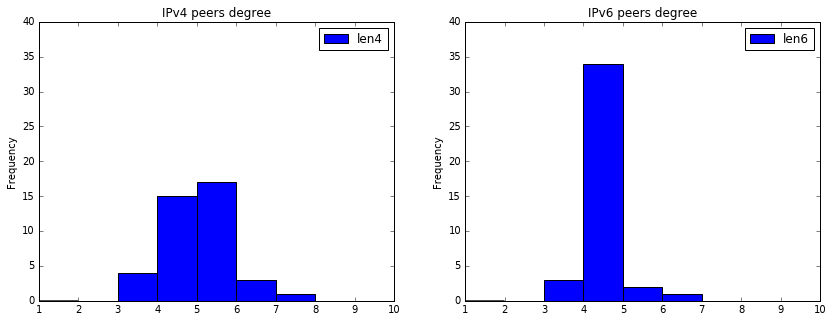

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2)

processed_data[['len4']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[0], ylim=(0,40), title='IPv4 peers degree')
processed_data[['len6']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[1], ylim=(0,40), title='IPv6 peers degree')

plt.show()

## RQ.2 AS path average length?

In [6]:
avg4 = processed_data['len4'].mean()
avg6 = processed_data['len6'].mean()

print('IPv4 average path length: {}'.format(avg4))
print('IPv6 average path length: {}'.format(avg6))

IPv4 average path length: 4.55
IPv6 average path length: 4.025


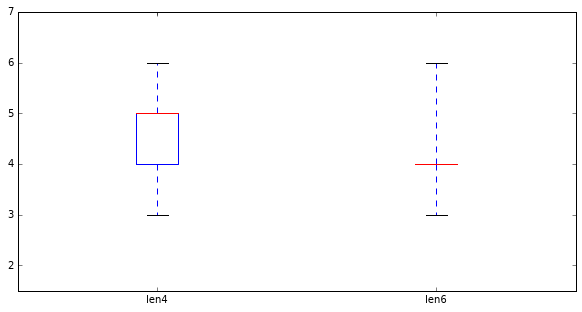

In [7]:
processed_data[['len4', 'len6']].plot.box(figsize=(10,5), ylim=(1.5,7))
plt.show()

## RQ.3 ASes most frequently seen?

### IPv4

In [9]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

res = []

for item in processed_data['path4']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv4 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 


Most frequently seen ASes in IPv4 AS paths:
8674	40
8966	8
35313	8
2497	4
2603	4
6730	3
2914	3
42708	3
8932	2
1257	2
41965	2
10429	2
12956	2
29691	2
42109	2
47872	1
50304	1
6661	1
209	1
29075	1
9044	1
3356	1
16735	1
24611	1
20965	1
31025	1
6762	1
2611	1
12586	1
1916	1


Most frequently seen per degree (degree is as seen from Root ASN)

In [10]:
max = processed_data['len4'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path4']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	8674	40
(*) Hop 2:
	35313	8
	2497	4
	2603	4
	6730	3
	42708	3
	1257	2
	12956	2
	1916	2
	42109	2
	2914	1
	6661	1
	209	1
	29075	1
	202032	1
	2611	1
	9044	1
	7575	1
	14840	1
	16735	1
(*) Hop 3:
	8966	8
	2914	3
	29691	3
	41965	2
	10429	2
	50304	1
	20612	1
	34146	1
	9304	1
	22548	1
	52888	1
	48166	1
	3356	1
	286	1
	20640	1
	24611	1
	20965	1
	13030	1
	62567	1
	7018	1
	49835	1
	31025	1
	6453	1
(*) Hop 4:
	8932	2
	1280	1
	262317	1
	57381	1
	29608	1
	59689	1
	6762	1
	14061	1
	53070	1
	51405	1
	680	1
	5396	1
	8758	1
	198249	1
	58308	1
	12586	1
	12859	1
	50620	1
	8426	1
	57118	1
(*) Hop 5:
	47872	2
	28329	1
	57821	1
(*) Hop 6:
	28917	1


### IPv6

In [11]:
res = []

for item in processed_data['path6']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv6 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 

Most frequently seen ASes in IPv6 AS paths:
8674	40
6939	27
8966	2
2603	2
35313	2
8932	1
6695	1
1836	1
41965	1
9264	1
42708	1
42109	1
702	1


most frequently seen ASes per degere

In [12]:
max = processed_data['len6'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path6']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	8674	40
(*) Hop 2:
	6939	27
	2603	2
	35313	2
	47872	1
	48166	1
	6695	1
	1836	1
	9264	1
	42708	1
	12859	1
	42109	1
	702	1
(*) Hop 3:
	8966	2
	1280	1
	20612	1
	198249	1
	34146	1
	53070	1
	41965	1
	52888	1
	51405	1
	5396	1
	262317	1
	7575	1
	9304	1
	50620	1
	58308	1
	57821	1
	286	1
	20640	1
	2914	1
	57381	1
	62567	1
	680	1
	28329	1
	7018	1
	49835	1
	14061	1
	202032	1
	29608	1
	57118	1
	8758	1
	59689	1
	14840	1
	22548	1
	29691	1
	1916	1
	8426	1
(*) Hop 4:
	8932	1
	6453	1
	13030	1
(*) Hop 5:
	28917	1


## RQ.4 For shorter IPv6 path, which ASes frequently appear as transit?

In [13]:
temp= []
for item in processed_data.iterrows():
#     print(item[1]['path4'])
    if item[1]['len4'] > item[1]['len6']:
#         print('v4: {}\tv6: {}'.format(item[1]['path4'], item[1]['path6']))
        for asn in item[1]['path6'][1:-1]:
            temp.append(asn)

results = most_common(temp)
for result in results:
    print('{}\t{}'.format(result[0], result[1]))

8674	22
6939	16
9264	1
8932	1
42708	1
41965	1
42109	1


## RQ.5 For peers with same path length but different path, how different is it?

calculate the percentage of different AS hop, and find out which ASes are frequently appear in the IPv6 path

In [14]:
temp = []
for item in processed_data.iterrows():
    if len(item[1]['path4']) == len(item[1]['path6']):
#         print('v4:{}\t\t\tv6:{}'.format(item[1]['path4'][1:-1], item[1]['path6'][1:-1]))
        diff_counter = 0
        path_length = len(item[1]['path4'])
        for i in range(0, path_length):
            if item[1]['path4'][i] != item[1]['path6'][i]:
                temp.append(item[1]['path6'][i])
                diff_counter += 1
        diff_pct = (diff_counter / path_length) * 100
        print('Peer {}: \tlength:{} \tdifference: {}%'.format(item[0], path_length, diff_pct))

print('\nMost common ASes appear in IPv6 path that differs with IPv4 path')
results = most_common(temp)
for result in results:
    print('\t{}\t{}'.format(result[0], result[1]))

Peer 286: 	length:4 	difference: 25.0%
Peer 2914: 	length:4 	difference: 25.0%
Peer 7018: 	length:4 	difference: 25.0%
Peer 9304: 	length:4 	difference: 25.0%
Peer 20612: 	length:4 	difference: 25.0%
Peer 20640: 	length:4 	difference: 25.0%
Peer 22548: 	length:4 	difference: 25.0%
Peer 29691: 	length:4 	difference: 25.0%
Peer 34146: 	length:4 	difference: 25.0%
Peer 49835: 	length:4 	difference: 25.0%
Peer 52888: 	length:4 	difference: 25.0%
Peer 62567: 	length:4 	difference: 25.0%

Most common ASes appear in IPv6 path that differs with IPv4 path
	6939	8
	2603	1
	1836	1
	702	1
	6695	1


## RQ.6 Can we correlate the path difference to their physical location? (based on the location of RIS collector)?

In [15]:
peer_location = processed_data.groupby('collector')
peer_location['collector'].count().sort_values(ascending=False)

collector
Sao Paulo, Brazil              7
SwissIX, Zurich                6
France-IX, Paris               5
RIPE NCC, Amsterdam            4
Palo Alto, USA                 4
New York (NY), USA             3
Frankfurt, Germany             3
Milan, Italy                   2
AMS-IX and NL-IX, Amsterdam    2
Stockholm, Sweden              1
Moscow, Russia                 1
LINX, London                   1
CATNIX, Barcelona              1
Name: collector, dtype: int64

### which collectors see the most peers with shorter IPv6 path?

In [16]:
v6_shorter = processed_data[processed_data.len4 > processed_data.len6].groupby('collector')
v6_shorter['collector'].count().sort_values(ascending=False)

collector
France-IX, Paris               5
SwissIX, Zurich                3
Sao Paulo, Brazil              3
RIPE NCC, Amsterdam            3
Palo Alto, USA                 2
Frankfurt, Germany             2
Stockholm, Sweden              1
Moscow, Russia                 1
Milan, Italy                   1
AMS-IX and NL-IX, Amsterdam    1
Name: collector, dtype: int64

### which collectors see the most peers with shorter IPv4 path?

In [17]:
v4_shorter = processed_data[processed_data.len4 < processed_data.len6].groupby('collector')
v4_shorter['collector'].count().sort_values(ascending=False)

collector
Sao Paulo, Brazil              2
Palo Alto, USA                 1
New York (NY), USA             1
Milan, Italy                   1
AMS-IX and NL-IX, Amsterdam    1
Name: collector, dtype: int64

# RQ: How do IPv4 and IPv6 catchment areas evolve over time?

Note that here we only use mutual peers that have different IPv4/IPv6 path

## RQ.1 IPv4/IPv6 peer degree distribution over time?

In [1]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests
from datetime import datetime
import pytz
import time
import csv
from pandas import DataFrame

utc = pytz.utc

start = datetime(2010, 7, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2014, 6, 1, 1, 0, 0)
prefix4 =  '192.36.148.17'
prefix6 = '2001:7fe::53'

csv_dir = 'datasets/i/'

*Helper methods*

In [2]:
col_map = {
    '00': 'RIPE NCC, Amsterdam',
    '01': 'LINX, London',
    '02': 'SFINX, Paris',
    '03': 'AMS-IX and NL-IX, Amsterdam',
    '04': 'CIXP, Geneva',
    '05': 'VIX, Vienna',
    '06': 'Otemachi, Japan',
    '07': 'Stockholm, Sweden',
    '08': 'San Jose (CA), USA',
    '09': 'Zurich, Switzerland',
    '10': 'Milan, Italy',
    '11': 'New York (NY), USA',
    '12': 'Frankfurt, Germany',
    '13': 'Moscow, Russia',
    '14': 'Palo Alto, USA',
    '15': 'Sao Paulo, Brazil',
    '16': 'Miami, USA',
    '18': 'CATNIX, Barcelona',
    '19': 'NAP Africa JB, Johannesburg',
    '20': 'SwissIX, Zurich',
    '21': 'France-IX, Paris',
}


def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
            coll = item['source_id'].split('-')[0]
            bgp_data[item['path'][0]] = {'path': list(deduplicate(item['path'])), 'collector': coll}
            peers.append(item['path'][0])
    return bgp_data, peers


def get_mutual_peer_with_diff_paths(timestamp):
    """
    get mutual peer with different IPv4/IPv6 paths
    """
    data4, peer4 = get_peers(prefix4, timestamp)
    data6, peer6 = get_peers(prefix6, timestamp)

    mutual_peers = list(set(peer4) & set(peer6))

    mutual_peers_diff = {}

    for peer in mutual_peers:
        if data4[peer]['path'] != data6[peer]['path']:
            mutual_peers_diff[peer] = {'path4': data4[peer]['path'], 'path6': data6[peer]['path'], 'collector': col_map[data4[peer]['collector']]}
    
    return mutual_peers_diff

### Get data, write to .csv file

Do it only once!!!

In [20]:
result = {}
cur_date = start
print('start.....')
while cur_date <= stop:
    # do something here
    utc_dt = utc.localize(cur_date)
    timestamp = int(time.mktime(utc_dt.timetuple()))
    
    mutual_peers_diff = get_mutual_peer_with_diff_paths(timestamp)

    processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')

    for index, row in processed_data.iterrows():
        processed_data.set_value(index, 'len4', len(row['path4']))
        processed_data.set_value(index, 'len6', len(row['path6']))
    
    path_file = '{}{}-path.csv'.format(csv_dir, timestamp)
    processed_data.to_csv(path_file, sep='\t')
    
    # increment cur_date
    year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
    month = 1 if cur_date.month == 12 else cur_date.month + 1
    cur_date = datetime(year, month, 1, 1, 0, 0)

print('stop...')

start.....
stop...


### Data Analysis
get peer's degree for both IPv4 and IPv6

In [3]:
import os

In [4]:
result4 = {}
result6 = {}
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4'].value_counts()
        result4[timestamp] = res4
        res6 = opened_file['len6'].value_counts()
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()
print('finish.')

finish.


### Plot

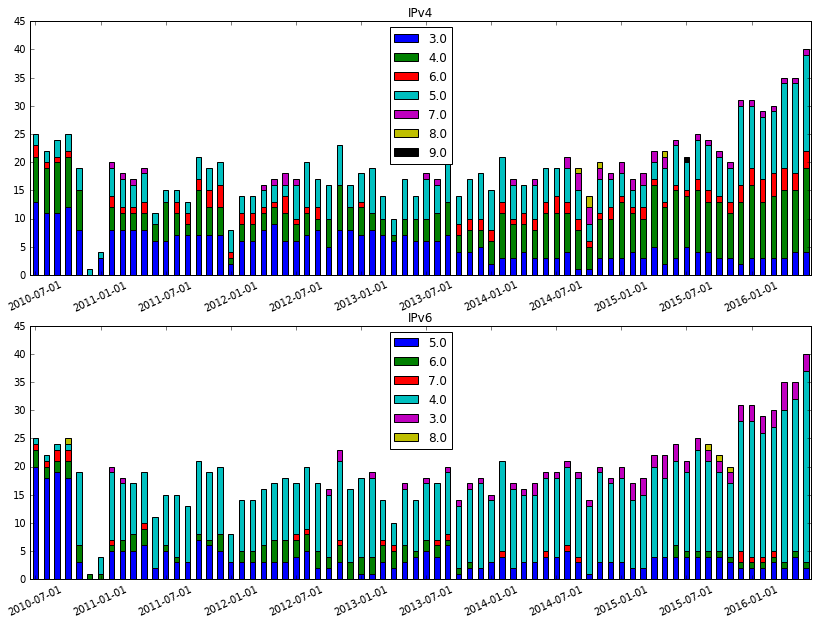

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1)

plot_result4 = DataFrame.from_dict(result4, orient='index')
plot_result6 = DataFrame.from_dict(result6, orient='index')

plot4 = plot_result4.plot.bar(stacked=True, ax=axes[0], figsize=(14,10), ylim=(0,45), title='IPv4')
plot6 = plot_result6.plot.bar(stacked=True, ax=axes[1], figsize=(14,10), ylim=(0,45),title='IPv6')

n = 6

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

## RQ.2 AS path average length?

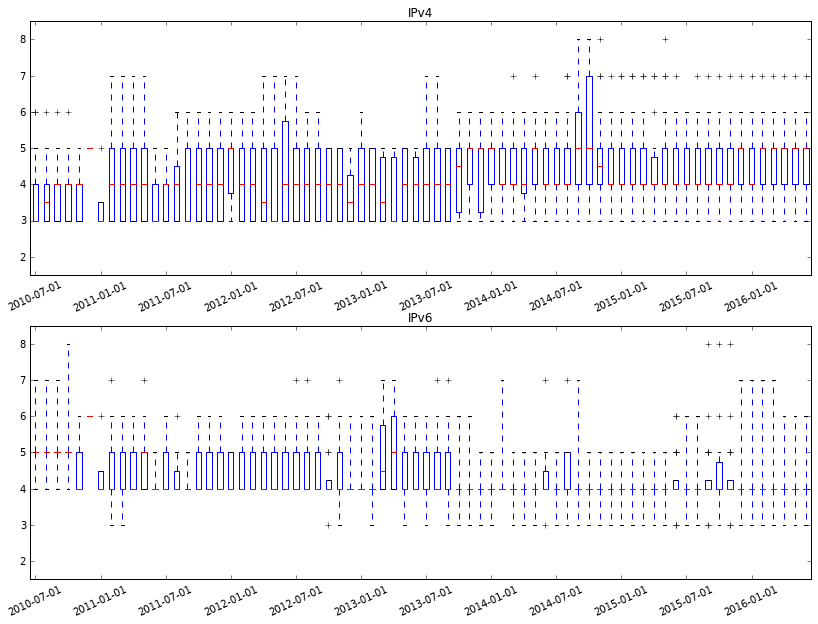

In [6]:
result4 = {}
result6 = {}
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4']
        res6 = opened_file['len6']
        result4[timestamp] = res4
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()

plot_result4 = DataFrame.from_dict(result4)
plot_result6 = DataFrame.from_dict(result6)


################
# Plot
################
fig, axes = plt.subplots(nrows=2, ncols=1)

plot4 = plot_result4.plot.box(figsize=(14,10), ax=axes[0], ylim=(1.5,8.5), title='IPv4')
plot6 = plot_result6.plot.box(figsize=(14,10), ax=axes[1], ylim=(1.5,8.5), title='IPv6')

n = 6

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

## RQ.3 Most frequently seen ASes on the path?

### IPv4

In [8]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path4']:
            # transform string of AS path into python's list
            path4 = item[1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            # exclude origin AS and probe AS
            for i in path4[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv4 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv4 AS paths (2010-07-01):
8674	25
2611	3
5459	2
2603	2
6762	1
2497	1
20965	1
6695	1
1257	1
1103	1

[*] Most frequently seen ASes in IPv4 AS paths (2010-08-01):
8674	22
2603	3
2611	2
2497	1
1125	1
6695	1
1257	1
5459	1
1103	1
3257	1

[*] Most frequently seen ASes in IPv4 AS paths (2010-09-01):
8674	24
5459	3
2603	2
2611	2
6762	2
16735	2
2497	1
1125	1
6695	1
1257	1

[*] Most frequently seen ASes in IPv4 AS paths (2010-10-01):
8674	25
5459	3
2603	2
2611	2
6762	2
16735	2
2497	1
1125	1
6695	1
1257	1

[*] Most frequently seen ASes in IPv4 AS paths (2010-11-01):
8674	19
6762	4
16735	3
2611	2
5459	2
6453	1
6695	1
3257	1
6939	1

[*] Most frequently seen ASes in IPv4 AS paths (2010-12-01):
3257	1
8674	1
2611	1

[*] Most frequently seen ASes in IPv4 AS paths (2011-01-01):
8674	4
3257	1
2611	1

[*] Most frequently seen ASes in IPv4 AS paths (2011-02-01):
8674	20
6762	5
16735	4
2611	3
10026	2
24151	2
7497	2
20965	1
1257	1
53131	1

[*] Most frequently seen ASes in 

### IPv6

In [9]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path6']:
            # transform string of AS path into python's list
            path6 = item[1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            # exclude origin AS and probe AS
            for i in path6[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv6 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv6 AS paths (2010-07-01):
8674	25
5459	25
3257	21
5413	3
2852	1
1103	1
6939	1
3549	1
1125	1

[*] Most frequently seen ASes in IPv6 AS paths (2010-08-01):
8674	22
5459	22
3257	17
5413	4
1103	1
3356	1
3549	1
1125	1

[*] Most frequently seen ASes in IPv6 AS paths (2010-09-01):
8674	24
5459	24
3257	19
5413	4
3549	2
2852	1
1103	1
1125	1
16735	1

[*] Most frequently seen ASes in IPv6 AS paths (2010-10-01):
8674	25
5459	25
3257	20
5413	4
6939	2
2852	1
23148	1
1103	1
20080	1
1125	1

[*] Most frequently seen ASes in IPv6 AS paths (2010-11-01):
8674	19
2914	6
2603	5
1257	4
3549	2
16735	2
12859	1
15685	1
6762	1
1299	1

[*] Most frequently seen ASes in IPv6 AS paths (2010-12-01):
29208	1
8674	1
6939	1
15685	1

[*] Most frequently seen ASes in IPv6 AS paths (2011-01-01):
8674	4
2914	2
6939	1
15685	1
29208	1
2603	1

[*] Most frequently seen ASes in IPv6 AS paths (2011-02-01):
8674	20
2914	7
2603	6
1257	3
6762	2
16735	2
6939	2
3549	2
53131	1
20965	1

[*] Most frequ

## RQ.4A For shorter IPv6 path, which ASes frequently appear as transit?

In [10]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] > item[1]['len6']:
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            for asn in path6[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))

[*] at 2010-07-01:
[*] at 2010-08-01:
[*] at 2010-09-01:
[*] at 2010-10-01:
[*] at 2010-11-01:
[*] at 2010-12-01:
[*] at 2011-01-01:
[*] at 2011-02-01:
	8674	3
	6939	2
[*] at 2011-03-01:
	8674	2
	6939	1
[*] at 2011-04-01:
	8674	2
	4651	2
	9931	2
	6939	1
[*] at 2011-05-01:
	8674	2
	4651	2
	9931	2
	6939	1
[*] at 2011-06-01:
[*] at 2011-07-01:
[*] at 2011-08-01:
	8674	3
	6939	2
	29208	1
	15685	1
[*] at 2011-09-01:
	8674	3
	29208	1
	1257	1
	6939	1
	15685	1
[*] at 2011-10-01:
	8674	3
	29208	1
	1257	1
	6939	1
	15685	1
[*] at 2011-11-01:
	8674	4
	6939	2
	29208	1
	1257	1
	15685	1
[*] at 2011-12-01:
	8674	4
	6939	2
	29208	1
	1257	1
	15685	1
[*] at 2012-01-01:
	8674	3
	6939	2
	2603	1
[*] at 2012-02-01:
	8674	4
	6939	3
	2603	1
[*] at 2012-03-01:
	8674	4
	6939	3
	2603	1
[*] at 2012-04-01:
	8674	4
	6939	2
	2497	1
	1257	1
[*] at 2012-05-01:
	8674	4
	6939	3
	2497	1
[*] at 2012-06-01:
	8674	5
	6939	4
	2497	1
	6695	1
[*] at 2012-07-01:
	8674	5
	6939	3
	1257	1
	2497	1
[*] at 2012-08-01:
	8674	7
	6939	6


## RQ.4b For shorter IPv6 path, how different is it?

In [11]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) > len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path4) - len(path6), (len(path4) - len(path6)) / len(path4) * 100))


---------------------------------------------------------------
 date: 2010-07-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2010-08-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2010-09-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2010-10-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2010-11-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2010-12-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2011-01-01
-----------------------------------

## RQ.5a For shorter IPv4 path, which ASes frequently appear as transit?

In [29]:
for file in sorted(os.listdir('datasets/m/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/m/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] < item[1]['len6']:
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            for asn in path4[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('\n[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))


[*] at 2008-03-01:
	1299	2

[*] at 2008-04-01:

[*] at 2008-05-01:
	1299	1

[*] at 2008-06-01:

[*] at 2008-07-01:

[*] at 2008-08-01:

[*] at 2008-09-01:

[*] at 2008-10-01:

[*] at 2008-11-01:

[*] at 2008-12-01:

[*] at 2009-01-01:

[*] at 2009-02-01:

[*] at 2009-03-01:

[*] at 2009-04-01:

[*] at 2009-05-01:

[*] at 2009-06-01:

[*] at 2009-07-01:

[*] at 2009-08-01:

[*] at 2009-09-01:

[*] at 2009-10-01:

[*] at 2009-11-01:

[*] at 2009-12-01:

[*] at 2010-01-01:
	3257	1

[*] at 2010-02-01:
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-03-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-04-01:
	3257	2
	1125	1
	1103	1

[*] at 2010-05-01:
	6453	1
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-06-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-07-01:

[*] at 2010-08-01:

[*] at 2010-09-01:

[*] at 2010-10-01:
	2200	1
	20965	1
	27750	1

[*] at 2010-11-01:
	2200	1
	24490	1
	20965	1

[*] at 2010-12-01:

[*] at 2011-01-01:
	2200	1
	24490	1
	20965	1

[*] at 2011-02-01:
	2200	1
	24490	1
	

## RQ.5b For shorter IPv4 path, how different is it?

In [13]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) < len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path6) - len(path4), (len(path6) - len(path4)) / len(path6) * 100))


---------------------------------------------------------------
 date: 2010-07-01
---------------------------------------------------------------
286	4	5	1	20.00%
1103	4	5	1	20.00%
1280	4	5	1	20.00%
1853	3	6	3	50.00%
2497	3	5	2	40.00%
2914	3	5	2	40.00%
4589	4	5	1	20.00%
6667	3	5	2	40.00%
6762	3	5	2	40.00%
8447	3	5	2	40.00%
8763	3	5	2	40.00%
9002	3	5	2	40.00%
12637	3	5	2	40.00%
13030	3	5	2	40.00%
13237	3	5	2	40.00%
19151	3	5	2	40.00%
20640	4	5	1	20.00%
22548	5	6	1	16.67%
29636	4	5	1	20.00%
30132	4	5	1	20.00%
34695	3	5	2	40.00%
196613	6	7	1	14.29%

---------------------------------------------------------------
 date: 2010-08-01
---------------------------------------------------------------
286	4	5	1	20.00%
1103	4	5	1	20.00%
1280	4	5	1	20.00%
1853	3	6	3	50.00%
2497	3	5	2	40.00%
2914	3	5	2	40.00%
4589	4	5	1	20.00%
6667	3	5	2	40.00%
6762	3	5	2	40.00%
8447	3	5	2	40.00%
8763	3	5	2	40.00%
9002	3	5	2	40.00%
13030	3	5	2	40.00%
13237	3	5	2	40.00%
19151	3	5	2	40.00%
20640	4	5	1	20.00%
22548	5	6

## RQ.6 For peers with same AS path length but different path, how different is it?

In [30]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp = []
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    for item in opened_file.iterrows():
        if len(item[1]['path4']) == len(item[1]['path6']):
            # transform string into list
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            
            diff_counter = 0
            path_length = len(path4)
            for i in range(0, path_length):
                if path4[i] != path6[i]:
                    temp.append(path6[i])
                    diff_counter += 1
            diff_pct = (diff_counter / path_length) * 100
            print('Peer {0}: \tlength:{1} \tdifference: {2:.2f}%'.format(item[0], path_length, diff_pct))
            

    print('\nMost common ASes appear in IPv6 path that differs with IPv4 path:')
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))



---------------------------------------------------------------
 date: 2010-07-01
---------------------------------------------------------------
Peer 3257: 	length:4 	difference: 25.00%
Peer 6881: 	length:5 	difference: 20.00%

Most common ASes appear in IPv6 path that differs with IPv4 path:
	5459	2

---------------------------------------------------------------
 date: 2010-08-01
---------------------------------------------------------------
Peer 3257: 	length:4 	difference: 25.00%
Peer 6881: 	length:5 	difference: 20.00%

Most common ASes appear in IPv6 path that differs with IPv4 path:
	5459	2

---------------------------------------------------------------
 date: 2010-09-01
---------------------------------------------------------------
Peer 3257: 	length:4 	difference: 25.00%
Peer 6881: 	length:5 	difference: 20.00%

Most common ASes appear in IPv6 path that differs with IPv4 path:
	5459	2

---------------------------------------------------------------
 date: 2010-10-01
-----

## RQ.7 Can we correlate the path difference to their physical location?

In [31]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        peer_location = opened_file.groupby('collector')
        result = peer_location['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2010-07-01
---------------------------------------------------------------
collector
Palo Alto, USA                 6
Frankfurt, Germany             5
VIX, Vienna                    3
RIPE NCC, Amsterdam            2
Milan, Italy                   2
AMS-IX and NL-IX, Amsterdam    2
Stockholm, Sweden              1
Sao Paulo, Brazil              1
New York (NY), USA             1
Moscow, Russia                 1
LINX, London                   1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2010-08-01
---------------------------------------------------------------
collector
Palo Alto, USA                 5
Frankfurt, Germany             5
VIX, Vienna                    3
RIPE NCC, Amsterdam            2
AMS-IX and NL-IX, Amsterdam    2
Stockholm, Sweden              1
Sao Paulo, Brazil              1
New York (NY), USA             1
Moscow, Russia               

### which collectors see the most peers with shorter IPv6 path?

In [33]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v6_shorter = opened_file[opened_file.len4 > opened_file.len6].groupby('collector')
        result = v6_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2010-07-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2010-08-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2010-09-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2010-10-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2010-11-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

------------------------------------------------------

### which collectors see the most peers with shorter IPv4 path?

In [34]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v4_shorter = opened_file[opened_file.len4 < opened_file.len6].groupby('collector')
        result = v4_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2010-07-01
---------------------------------------------------------------
collector
Palo Alto, USA                 5
Frankfurt, Germany             4
VIX, Vienna                    3
Milan, Italy                   2
AMS-IX and NL-IX, Amsterdam    2
Stockholm, Sweden              1
Sao Paulo, Brazil              1
RIPE NCC, Amsterdam            1
New York (NY), USA             1
Moscow, Russia                 1
LINX, London                   1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2010-08-01
---------------------------------------------------------------
collector
Palo Alto, USA                 5
Frankfurt, Germany             4
VIX, Vienna                    3
AMS-IX and NL-IX, Amsterdam    2
Stockholm, Sweden              1
Sao Paulo, Brazil              1
RIPE NCC, Amsterdam            1
New York (NY), USA             1
Moscow, Russia               